1.Загрузить данные в Dataframe, если у какой-то записи из файлов с информацией о пациентах отсутствует CaseID, присвоить (учесть, что он не должен встречаться в других файлах)

Проверить уникальность записей. Если есть повторяющиеся, оставлять последнее пребывание с стационаре.

Объединить данные из таблиц

Проверить, есть ли пустые значения в данных по показателям

Создать dataframe только с данными пациентов, у которых известен исход (жив/мертв).

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Mounted at /content/drive


In [2]:
df_mono = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/пакеты проект/БД_с_моно_full.xlsx')
df_no_mono = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/пакеты проект/БД_без_моно_full.xlsx')
df_mono=df_mono.rename(columns={"Vacin": "Vac"}, errors="raise")

print(df_mono.Ther.unique())
print(df_no_mono.Ther.unique())

d_dimer = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/пакеты проект/Показатель_D.xlsx')
ferritin = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/пакеты проект/Показатель_F.xlsx')
d_dimer = d_dimer.drop(['Показатель', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Записей', 'Уникальных'], axis=1)
d_dimer = d_dimer[pd.to_numeric(d_dimer['Результат_D'], errors='coerce').notnull()]

ferritin = ferritin.drop(['Дата результата', 'IDS', 'Дата взятия', 'Показатель_F', 'Unnamed: 6', 'Unnamed: 7'], axis=1)
ferritin = ferritin[pd.to_numeric(ferritin['Результат'], errors='coerce').notnull()]

print(d_dimer.shape)
print(ferritin.shape)

['ИНФ (тяжелое течение) с терапией без ЛП'
 'ИНФ (среднетяжелое течение) с терапией без ЛП'
 'ИНФ (тяжелое течение) с терапией и ЛП'
 'ИНФ (среднетяжелое течение) с терапией и ЛП'
 'ИНФ (крайне тяжелое течение) с терапией без ЛП'
 'ИНФ (крайне  тяжелое течение) с терапией и ЛП']
['ИНФ (среднетяжелое течение) без ЛП и терапии'
 'ИНФ (тяжелое течение) без ЛП и терапии'
 'ИНФ (среднетяжелое течение) с ЛП без терапии'
 'ИНФ (крайне тяжелое течение) без ЛП и терапии']
(8893, 2)
(10372, 2)


In [3]:
df = pd.concat([df_mono, df_no_mono])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8746 entries, 0 to 6261
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   CaseID   7958 non-null   float64       
 1   Gender   8746 non-null   object        
 2   Age      8746 non-null   int64         
 3   Start    8746 non-null   datetime64[ns]
 4   End      8746 non-null   datetime64[ns]
 5   Ther     8746 non-null   object        
 6   Outcome  8746 non-null   object        
 7   Vac      8007 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 615.0+ KB


In [4]:
df.loc[df['Vac'].isna(), 'Vac'] = 'Нет'

In [5]:
df['CaseID'].isna().sum()

788

In [6]:
d_dimer[d_dimer.duplicated(subset=['CaseID'], keep='last')]

,CaseID,Результат_D
25,386318,241.7
29,389746,222.77
55,380956,331.9
69,385579,284
119,185557,88.3
...,...,...
10446,389143,97.9
10478,384348,1813
10496,350168,135.8
10500,385404,159.2


In [7]:
d_dimer = d_dimer.drop_duplicates(subset=['CaseID'], keep='last')
ferritin = ferritin.drop_duplicates(subset=['CaseID'], keep='last')
print(d_dimer.shape)
print(ferritin.shape)

(8514, 2)
(10005, 2)


In [8]:
df_merged = pd.merge(pd.merge(df.dropna(subset='CaseID'), ferritin, on='CaseID'), d_dimer, on='CaseID')
df_merged = pd.concat([df_merged, df[df['CaseID'].isna()]])
df_merged

,CaseID,Gender,Age,Start,End,Ther,Outcome,Vac,Результат,Результат_D
0,383563.0,ж,46,2021-09-30,2021-10-09,ИНФ (тяжелое течение) с терапией без ЛП,Выписан,Нет,66.13,77.62
1,386318.0,ж,92,2021-12-05,2022-01-05,ИНФ (тяжелое течение) с терапией без ЛП,Выписан,Нет,177.3,57.9
2,386318.0,ж,92,2022-01-19,2022-02-01,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,177.3,57.9
3,238599.0,ж,55,2021-07-08,2021-07-23,ИНФ (среднетяжелое течение) с терапией без ЛП,Выписан,Нет,872.5,83.51
4,387627.0,м,74,2022-01-07,2022-02-02,ИНФ (среднетяжелое течение) с терапией без ЛП,Выписан,Нет,534.3,604
...,...,...,...,...,...,...,...,...,...,...
6194,NaN,м,58,2021-06-22,2021-06-26,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,NaN,NaN
6198,NaN,ж,68,2021-06-23,2021-07-01,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,NaN,NaN
6215,NaN,ж,40,2021-06-19,2021-06-25,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,NaN,NaN
6229,NaN,ж,75,2021-06-16,2021-07-01,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,NaN,NaN


In [ ]:
#Теперь у пациентов с пустыми CaseID нет показателей д димера и ферритина - избавимся от них

In [9]:
df_merged = df_merged.dropna(subset='CaseID').sort_values(by=['CaseID', 'End'], ascending=[True, False]).drop_duplicates(subset='CaseID', keep='first')

In [10]:
df_merged

,CaseID,Gender,Age,Start,End,Ther,Outcome,Vac,Результат,Результат_D
178,66.0,ж,81,2022-01-24,2022-02-01,ИНФ (тяжелое течение) с терапией и ЛП,Умер,Нет,60.67,1606
2229,731.0,ж,82,2021-08-13,2021-08-23,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,968.2,1186
2245,1122.0,м,86,2021-10-03,2021-10-15,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,81.99,2104
2246,1142.0,м,58,2021-10-14,2021-10-26,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,518.5,476.9
2274,1972.0,ж,77,2021-12-02,2021-12-17,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,677.9,360.8
...,...,...,...,...,...,...,...,...,...,...
5980,389589.0,м,82,2022-02-13,2022-02-16,ИНФ (тяжелое течение) без ЛП и терапии,Умер,Нет,2025,2000
6613,389607.0,м,53,2022-02-13,2022-02-16,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Ковивак,1650,189.4
2207,389756.0,м,86,2022-02-16,2022-02-17,ИНФ (тяжелое течение) с терапией и ЛП,Умер,Нет,1764,563.4
6128,389763.0,ж,91,2022-02-16,2022-02-19,ИНФ (тяжелое течение) без ЛП и терапии,Умер,Нет,1705,900.1


In [11]:
df_merged.Outcome.unique()

array(['Умер', 'Выписан', 'Переведён в др. ЛПУ',
       'Переведён на другой профиль коек'], dtype=object)

In [12]:
df_merged = df_merged.loc[(df_merged['Outcome'] == 'Выписан') | (df_merged['Outcome'] == 'Умер')]
df_merged

,CaseID,Gender,Age,Start,End,Ther,Outcome,Vac,Результат,Результат_D
178,66.0,ж,81,2022-01-24,2022-02-01,ИНФ (тяжелое течение) с терапией и ЛП,Умер,Нет,60.67,1606
2229,731.0,ж,82,2021-08-13,2021-08-23,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,968.2,1186
2245,1122.0,м,86,2021-10-03,2021-10-15,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,81.99,2104
2246,1142.0,м,58,2021-10-14,2021-10-26,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,518.5,476.9
2274,1972.0,ж,77,2021-12-02,2021-12-17,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,677.9,360.8
...,...,...,...,...,...,...,...,...,...,...
5980,389589.0,м,82,2022-02-13,2022-02-16,ИНФ (тяжелое течение) без ЛП и терапии,Умер,Нет,2025,2000
6613,389607.0,м,53,2022-02-13,2022-02-16,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Ковивак,1650,189.4
2207,389756.0,м,86,2022-02-16,2022-02-17,ИНФ (тяжелое течение) с терапией и ЛП,Умер,Нет,1764,563.4
6128,389763.0,ж,91,2022-02-16,2022-02-19,ИНФ (тяжелое течение) без ЛП и терапии,Умер,Нет,1705,900.1


**2. Привести данные описательной статистики для группы пациентов, которым вводились и не вводились препараты (% м и ж, средний возраст, % исходов в группах). Визуализировать результаты.**

In [13]:
df_mono = df_merged.loc[(df_merged['Ther'] == 'ИНФ (тяжелое течение) с терапией без ЛП') |
          (df_merged['Ther'] == 'ИНФ (среднетяжелое течение) с терапией без ЛП') |
          (df_merged['Ther'] == 'ИНФ (тяжелое течение) с терапией и ЛП') |
          (df_merged['Ther'] == 'ИНФ (среднетяжелое течение) с терапией и ЛП') |
          (df_merged['Ther'] == 'ИНФ (крайне тяжелое течение) с терапией без ЛП') |
          (df_merged['Ther'] == 'ИНФ (крайне  тяжелое течение) с терапией и ЛП')]
df_no_mono = df_merged.loc[(df_merged['Ther'] == 'ИНФ (среднетяжелое течение) без ЛП и терапии') |
          (df_merged['Ther'] == 'ИНФ (тяжелое течение) без ЛП и терапии') |
          (df_merged['Ther'] == 'ИНФ (среднетяжелое течение) с ЛП без терапии') |
          (df_merged['Ther'] == 'ИНФ (крайне тяжелое течение) без ЛП и терапии')]

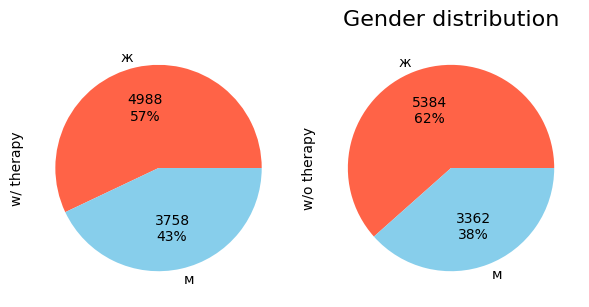

In [14]:
from matplotlib import pyplot as plt

def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

df_mono.groupby('Gender').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                 colors=['tomato', 'skyblue'], ax=ax1)
df_no_mono.groupby('Gender').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                 colors=['tomato', 'skyblue'], ax=ax2)
plt.title(
    label="Gender distribution",
    fontdict={"fontsize":16},
    pad=10
)
ax1.set_ylabel('w/ therapy', size=10)
ax2.set_ylabel('w/o therapy', size=10)
plt.tight_layout()
plt.show()

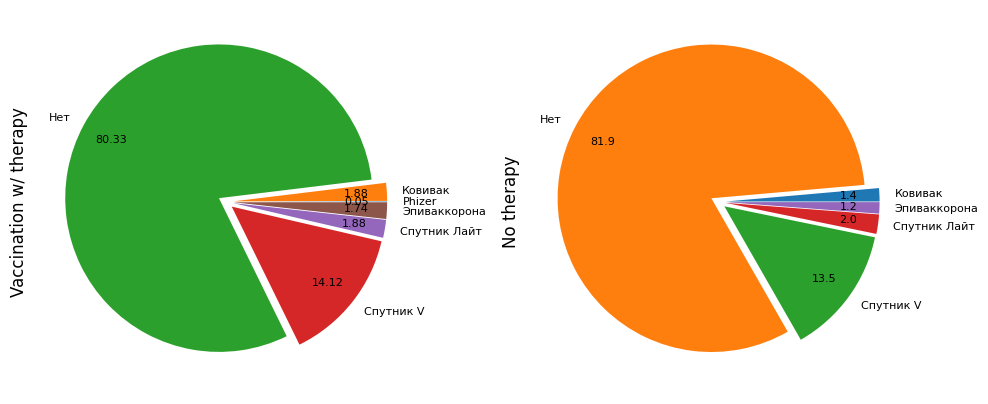

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

df_mono.groupby('Vac').size().plot(kind='pie', autopct="%.2f", textprops={'fontsize': 8},
                                   ax=ax1, pctdistance=0.80, explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
df_no_mono.groupby('Vac').size().plot(kind='pie', autopct="%.1f", textprops={'fontsize': 8},
                                      ax=ax2, pctdistance=0.80, explode=[0.05, 0.05, 0.05, 0.05, 0.05])

ax1.set_ylabel('Vaccination w/ therapy', size=12)
ax2.set_ylabel('No therapy', size=12)

plt.tight_layout()
plt.show()

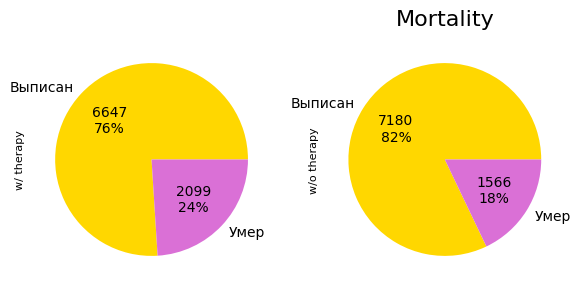

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

df_mono.groupby('Outcome').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                 colors=['gold', 'orchid'], ax=ax1)
df_no_mono.groupby('Outcome').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                 colors=['gold', 'orchid'], ax=ax2)

plt.title(
    label="Mortality",
    fontdict={"fontsize":16},
    pad=10
)
ax1.set_ylabel('w/ therapy', size=8)
ax2.set_ylabel('w/o therapy', size=8)
plt.tight_layout()
plt.show()

In [17]:
df_no_mono.describe()

,CaseID,Age
count,4670.000000,4670.000000
mean,349960.371949,64.576445
std,86163.176137,17.167077
min,731.000000,18.000000
25%,380079.250000,53.000000
50%,382487.000000,67.000000
75%,385361.000000,79.000000
max,389785.000000,100.000000


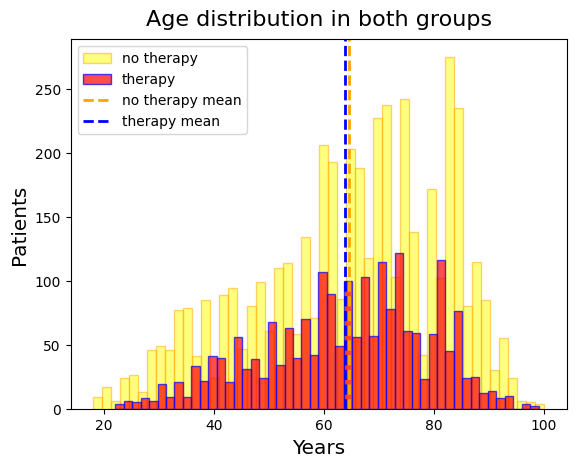

In [18]:
plt.hist(df_no_mono['Age'], bins=50, label='no therapy', alpha=.5, edgecolor='orange', color='yellow')
plt.hist(df_mono['Age'], bins=50, label='therapy', alpha=.7, edgecolor='blue', color='red')
plt.title(
    label="Age distribution in both groups",
    fontdict={"fontsize":16},
    pad=10
)
plt.axvline(df_no_mono['Age'].mean(), label='no therapy mean', color='orange', linestyle='dashed', linewidth=2)
plt.axvline(df_mono['Age'].mean(), color='blue', label='therapy mean', linestyle='dashed', linewidth=2)
plt.legend()
plt.ylabel('Patients', size='x-large')
plt.xlabel('Years', size= 'x-large')
plt.show()

**3. Создать пары пациентов из 2ух групп по правилу**
- **один пол**
- **возраст +/- 3 года**
- **уровень показатель_D +/- 10%**
- **уровень показатель_F +/- 10%**
- **схожая тяжесть заболевания (крайне тяжелые и тяжелые – одна группа, среднетяжелые – вторая группа)**

**Как изменятся группы, если добавить дополнительный критерий - одинаковый статус вакцинации**

In [19]:
df_mono.sort_index(inplace=True)
df_mono

<ipython-input-19-248ddd158c2e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mono.sort_index(inplace=True)


,CaseID,Gender,Age,Start,End,Ther,Outcome,Vac,Результат,Результат_D
0,383563.0,ж,46,2021-09-30,2021-10-09,ИНФ (тяжелое течение) с терапией без ЛП,Выписан,Нет,66.13,77.62
3,238599.0,ж,55,2021-07-08,2021-07-23,ИНФ (среднетяжелое течение) с терапией без ЛП,Выписан,Нет,872.5,83.51
4,387627.0,м,74,2022-01-07,2022-02-02,ИНФ (среднетяжелое течение) с терапией без ЛП,Выписан,Нет,534.3,604
5,382371.0,ж,61,2021-09-01,2021-10-01,ИНФ (тяжелое течение) с терапией без ЛП,Выписан,Нет,1133,449.6
6,383786.0,м,69,2021-10-04,2021-10-29,ИНФ (тяжелое течение) с терапией без ЛП,Выписан,Нет,1583,367.6
...,...,...,...,...,...,...,...,...,...,...
2209,385894.0,ж,56,2021-11-23,2021-12-09,ИНФ (среднетяжелое течение) с терапией без ЛП,Выписан,Нет,140,987.2
2210,384105.0,ж,74,2021-10-09,2021-11-03,ИНФ (тяжелое течение) с терапией без ЛП,Выписан,Нет,429,1067
2211,385476.0,ж,76,2021-11-10,2021-11-23,ИНФ (среднетяжелое течение) с терапией без ЛП,Выписан,Нет,1584,2488
2212,384403.0,м,59,2021-10-15,2021-10-29,ИНФ (тяжелое течение) с терапией без ЛП,Умер,Нет,1610,434.4


In [ ]:
#df_no_mono['Age'].plot.kde()

In [20]:
df_mono = df_mono.sort_values(by=['Age'])
df_no_mono = df_no_mono.sort_values(by=['Age'])

In [21]:
df_pairs = pd.merge(df_mono, df_no_mono, how='cross')

In [22]:
df_pairs = df_pairs[(df_pairs['Age_x'].to_numpy() - 3 <= df_pairs['Age_y'].to_numpy()) &
       (df_pairs['Age_x'].to_numpy() + 3 >= df_pairs['Age_y'].to_numpy()) &
       (df_pairs['Результат_x'].to_numpy() * 0.9 <= df_pairs['Результат_y'].to_numpy()) &
       (df_pairs['Результат_x'].to_numpy() * 1.1 >= df_pairs['Результат_y'].to_numpy()) &
       (df_pairs['Результат_D_x'].to_numpy() * 0.9 <= df_pairs['Результат_D_y'].to_numpy()) &
       (df_pairs['Результат_D_x'].to_numpy() * 1.1 >= df_pairs['Результат_D_y'].to_numpy()) &
       (df_pairs['Gender_x'].to_numpy() == df_pairs['Gender_y'].to_numpy()) &
       (df_pairs['Ther_x'].str.contains('средне') & df_pairs['Ther_y'].str.contains('средне') |
        ~df_pairs['Ther_x'].str.contains('средне') & ~df_pairs['Ther_y'].str.contains('средне'))]

In [23]:
df_pairs = df_pairs.drop_duplicates(subset=['CaseID_y'])
df_pairs = df_pairs.drop_duplicates(subset=['CaseID_x'])
df_pairs

,CaseID_x,Gender_x,Age_x,Start_x,End_x,Ther_x,Outcome_x,Vac_x,Результат_x,Результат_D_x,CaseID_y,Gender_y,Age_y,Start_y,End_y,Ther_y,Outcome_y,Vac_y,Результат_y,Результат_D_y
4691,259359.0,м,22,2021-08-20,2021-08-30,ИНФ (среднетяжелое течение) с терапией без ЛП,Выписан,Нет,265.2,43.49,385417.0,м,21,2021-11-08,2021-11-15,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Спутник Лайт,263.1,47.33
32746,302531.0,м,25,2021-07-25,2021-07-30,ИНФ (среднетяжелое течение) с терапией без ЛП,Выписан,Нет,513.9,198.7,381945.0,м,25,2021-08-19,2021-08-20,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,538,198.6
65492,236773.0,ж,26,2021-07-09,2021-07-16,ИНФ (среднетяжелое течение) с терапией без ЛП,Выписан,Нет,158.3,188.51,379596.0,ж,28,2021-06-24,2021-06-30,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,150.6,192.4
88919,387020.0,м,28,2021-12-22,2022-01-03,ИНФ (среднетяжелое течение) с терапией без ЛП,Выписан,Нет,664.9,129.7,381308.0,м,31,2021-08-01,2021-08-11,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,704,139.8
93463,383741.0,ж,28,2021-10-04,2021-10-12,ИНФ (среднетяжелое течение) с терапией без ЛП,Выписан,Нет,167.2,581.8,382433.0,ж,25,2021-09-03,2021-09-10,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,180.7,557.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9760083,98824.0,ж,90,2021-11-28,2021-12-10,ИНФ (среднетяжелое течение) с терапией без ЛП,Выписан,Спутник V,636.4,1007,387159.0,ж,88,2021-12-25,2022-01-11,ИНФ (среднетяжелое течение) без ЛП и терапии,Умер,Нет,671.2,1096
9788245,388957.0,ж,90,2022-02-03,2022-02-11,ИНФ (среднетяжелое течение) с терапией без ЛП,Выписан,Нет,336.3,291,379747.0,ж,92,2021-06-26,2021-07-12,ИНФ (среднетяжелое течение) без ЛП и терапии,Умер,Нет,342,279.98
9834843,380037.0,ж,92,2021-07-01,2021-07-21,ИНФ (тяжелое течение) с терапией без ЛП,Выписан,Нет,1233,1062.02,384961.0,ж,89,2021-10-28,2021-11-05,ИНФ (тяжелое течение) без ЛП и терапии,Умер,Нет,1284,968.9
9839672,267127.0,ж,92,2021-08-26,2021-09-08,ИНФ (среднетяжелое течение) с терапией без ЛП,Выписан,Нет,1427,466.7,383020.0,ж,95,2021-09-18,2021-10-13,ИНФ (среднетяжелое течение) без ЛП и терапии,Выписан,Нет,1334,512.3


In [24]:
df_pairs_with_vac = df_pairs[((df_pairs['Vac_x'].to_numpy() == 'Нет') & (df_pairs['Vac_x'].to_numpy() == 'Нет')) |
                             ((df_pairs['Vac_x'].to_numpy() != 'Нет') & (df_pairs['Vac_x'].to_numpy() != 'Нет'))]
df_pairs.equals(df_pairs_with_vac)

True

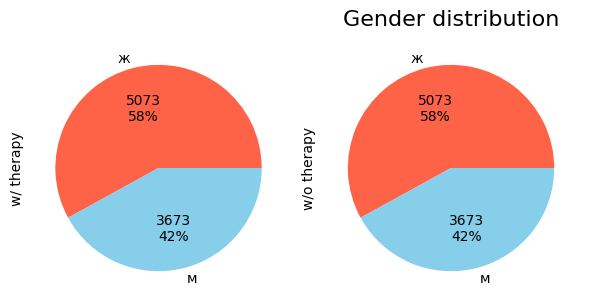

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

df_pairs.groupby('Gender_x').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                 colors=['tomato', 'skyblue'], ax=ax1)
df_pairs.groupby('Gender_y').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                 colors=['tomato', 'skyblue'], ax=ax2)
plt.title(
    label="Gender distribution",
    fontdict={"fontsize":16},
    pad=10
)
ax1.set_ylabel('w/ therapy', size=10)
ax2.set_ylabel('w/o therapy', size=10)
plt.tight_layout()
plt.show()

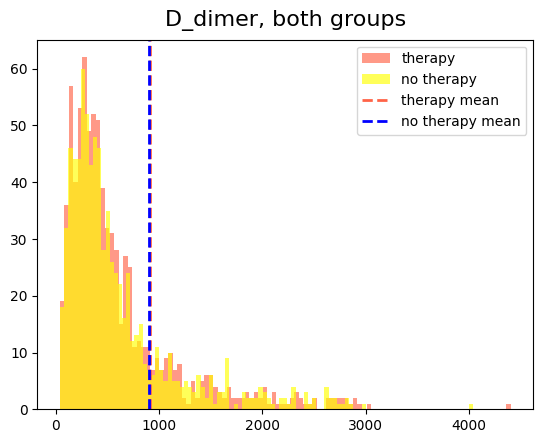

In [26]:
plt.hist(df_pairs['Результат_D_x'], bins=100, label='therapy', alpha=.65, color='tomato')
plt.hist(df_pairs['Результат_D_y'], bins=100, label='no therapy', alpha=.65, color='yellow')
plt.title(
    label="D_dimer, both groups",
    fontdict={"fontsize":16},
    pad=10
)
plt.axvline(df_pairs['Результат_x'].mean(), label='therapy mean', color='tomato', linestyle='dashed', linewidth=2)
plt.axvline(df_pairs['Результат_y'].mean(), color='blue', label='no therapy mean', linestyle='dashed', linewidth=2)
plt.legend()
plt.show()

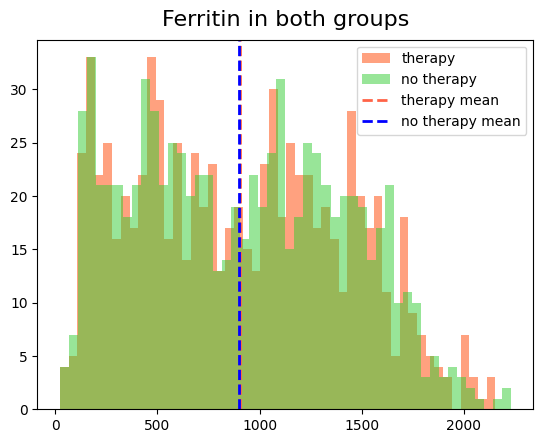

In [27]:
plt.hist(df_pairs['Результат_x'], bins=50, label='therapy', alpha=.5, color='orangered')
plt.hist(df_pairs['Результат_y'], bins=50, label='no therapy', alpha=.5, color='limegreen')
plt.title(
    label="Ferritin in both groups",
    fontdict={"fontsize":16},
    pad=10
)
plt.axvline(df_pairs['Результат_x'].mean(), label='therapy mean', color='tomato', linestyle='dashed', linewidth=2)
plt.axvline(df_pairs['Результат_y'].mean(), color='blue', label='no therapy mean', linestyle='dashed', linewidth=2)
plt.legend()
plt.show()

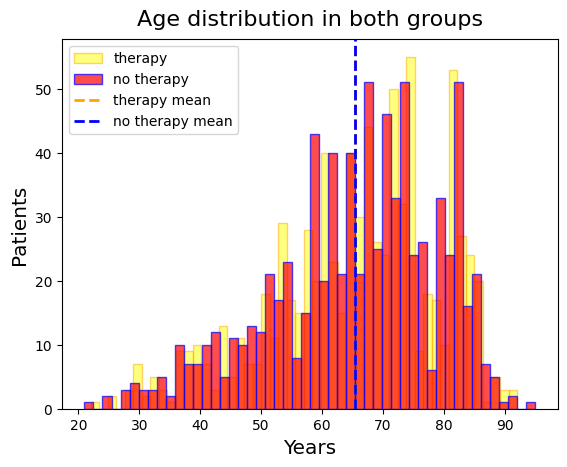

In [28]:
plt.hist(df_pairs['Age_x'], bins=50, label='therapy', alpha=.5, edgecolor='orange', color='yellow')
plt.hist(df_pairs['Age_y'], bins=50, label='no therapy', alpha=.7, edgecolor='blue', color='red')
plt.title(
    label="Age distribution in both groups",
    fontdict={"fontsize":16},
    pad=10
)
plt.axvline(df_pairs['Age_x'].mean(), label='therapy mean', color='orange', linestyle='dashed', linewidth=2)
plt.axvline(df_pairs['Age_y'].mean(), color='blue', label='no therapy mean', linestyle='dashed', linewidth=2)
plt.legend()
plt.ylabel('Patients', size='x-large')
plt.xlabel('Years', size= 'x-large')
plt.show()

**4. Оценить сопоставимость групп по указанным факторам с приведением показателя отсутствия статистической значимости различий**

Тут проверяем гипотезу об однородности для возраста, d_dimer, ferritin:

H0: две выборки имеют одинаковое распределение.

H1: распределены не одинаково.

scipy: ks_2samp: two-sided: The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical. The statistic is the maximum absolute difference between the empirical distribution functions of the samples.

In [29]:
from scipy import stats
stats.ks_2samp(df_pairs['Age_x'].to_numpy(), df_pairs['Age_y'].to_numpy())

KstestResult(statistic=0.012315270935960592, pvalue=0.999999981498312, statistic_location=61, statistic_sign=-1)

Тут p-value сильно больше заданного уровня значимости (обычно 0.05), не можем отвергнуть нулевую гипотезу. Можно сделать вывод, что распределения выборок не отличаются значимо друг от друга.
pvalue=0.9999999998363613 >> 0.05, поэтому можно принять нулевую гипотезу и сделать вывод, что возрасты в колонках 'Age_x' и 'Age_y' распределены одинаково.

In [30]:
stats.ks_2samp(df_pairs['Результат_x'].to_numpy(), df_pairs['Результат_y'].to_numpy())

KstestResult(statistic=0.014778325123152709, pvalue=0.9999926646636688, statistic_location=1687, statistic_sign=-1)

In [31]:
stats.ks_2samp(df_pairs['Результат_D_x'].to_numpy(), df_pairs['Результат_D_y'].to_numpy())

KstestResult(statistic=0.019704433497536946, pvalue=0.9975114741197338, statistic_location=449.4, statistic_sign=-1)

Сравнить полученные группы по исходам, визуализировать:
- жив/умер
- для живых - быстрее ли выздоравливали (=сроки госпитализации)

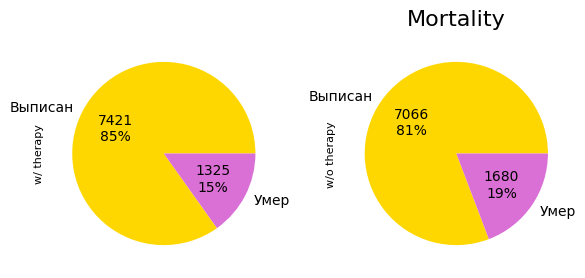

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

df_pairs.groupby('Outcome_x').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                 colors=['gold', 'orchid'], ax=ax1)
df_pairs.groupby('Outcome_y').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                 colors=['gold', 'orchid'], ax=ax2)

plt.title(
    label="Mortality",
    fontdict={"fontsize":16},
    pad=10
)
ax1.set_ylabel('w/ therapy', size=8)
ax2.set_ylabel('w/o therapy', size=8)
plt.tight_layout()
plt.show()

<Axes: >

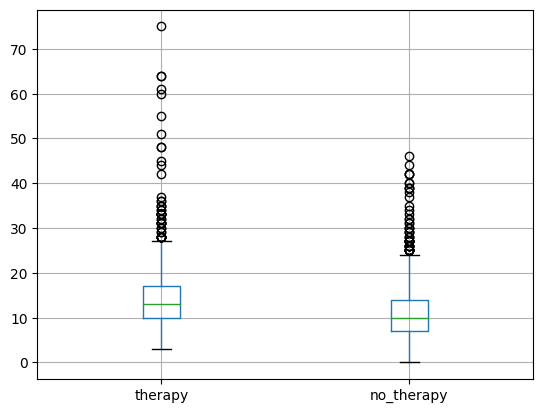

In [33]:
d={'therapy': (df_pairs['End_x']-df_pairs['Start_x']).dt.days, 'no_therapy': (df_pairs['End_y']-df_pairs['Start_y']).dt.days}
df_days = pd.DataFrame(data=d)
df_days.boxplot()

In [34]:
df_days.describe()

,therapy,no_therapy
count,812.000000,812.000000
mean,14.456897,11.374384
std,7.790687,7.066374
min,3.000000,0.000000
25%,10.000000,7.000000
50%,13.000000,10.000000
75%,17.000000,14.000000
max,75.000000,46.000000


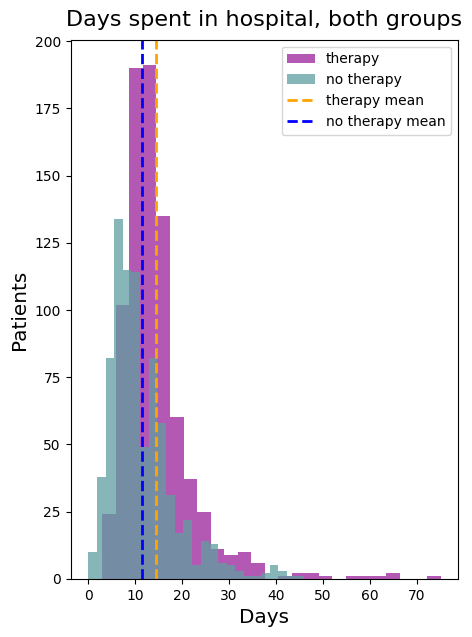

In [35]:
fig = plt.figure(figsize=(5, 7))
plt.hist(df_days['therapy'], bins=25, label='therapy', alpha=.65, color='darkmagenta')
plt.hist(df_days['no_therapy'], bins=25, label='no therapy', alpha=.75, color='cadetblue')
plt.title(
    label="Days spent in hospital, both groups",
    fontdict={"fontsize":16},
    pad=10
)
plt.axvline(df_days['therapy'].mean(), label='therapy mean', color='orange', linestyle='dashed', linewidth=2)
plt.axvline(df_days['no_therapy'].mean(), color='blue', label='no therapy mean', linestyle='dashed', linewidth=2)
plt.legend()
plt.ylabel('Patients', size='x-large')
plt.xlabel('Days', size= 'x-large')
plt.show()

H0: средние значения сроков госпитализации с терапией и без терапии равны

H1: средние значения сроков госпитализации с терапией больше, чем без терапии

alpha = 0.05

df = 812 + 812 - 2 = 1622

t_statistics = (14.45689 - 11.374384)/np.sqrt((7.790687^2)/812 + (7.066374^2)/812)



p-value << alpha => отвергаем нулевую гипотезу на уровне значимости alpha=0.05, средние сроки госпитализации значимо отличаются.

In [36]:
stats.ttest_ind(df_days['therapy'], df_days['no_therapy'])

TtestResult(statistic=8.351210057105726, pvalue=1.4300955669937364e-16, df=1622.0)

In [81]:
df_outcome = pd.DataFrame(data={'ther': pd.concat([df_pairs['Ther_x'], df_pairs['Ther_y']]), 'outcome' : pd.concat([df_pairs['Outcome_x'], df_pairs['Outcome_y']])})

In [90]:
df_outcome.loc[((df_outcome['ther'] == 'ИНФ (тяжелое течение) с терапией без ЛП') |
           (df_outcome['ther'] == 'ИНФ (среднетяжелое течение) с терапией без ЛП') |
           (df_outcome['ther'] == 'ИНФ (тяжелое течение) с терапией и ЛП') |
           (df_outcome['ther'] == 'ИНФ (среднетяжелое течение) с терапией и ЛП') |
           (df_outcome['ther'] == 'ИНФ (крайне тяжелое течение) с терапией без ЛП') |
           (df_outcome['ther'] == 'ИНФ (крайне  тяжелое течение) с терапией и ЛП')), 'ther'] = 'с терапией'


df_outcome.loc[((df_outcome['ther'] == 'ИНФ (среднетяжелое течение) без ЛП и терапии') |
           (df_outcome['ther'] == 'ИНФ (тяжелое течение) без ЛП и терапии') |
           (df_outcome['ther'] == 'ИНФ (среднетяжелое течение) с ЛП без терапии') |
           (df_outcome['ther'] == 'ИНФ (крайне тяжелое течение) без ЛП и терапии')), 'ther'] = 'без терапии'

In [97]:
pd.crosstab(df_outcome['ther'], df_outcome['outcome'], normalize='index')

outcome,Выписан,Умер
ther,,
без терапии,0.807882,0.192118
с терапией,0.848522,0.151478


alpha=0.05

H0: факт терапии и исход не взаимосвязаны между собой

H1: факт терапии и исход взаимосвязаны между собой

pvalue = 0.035279644791368976, отвергаем H0.

In [101]:
stats.chi2_contingency(pd.crosstab(df_outcome['ther'], df_outcome['outcome']))

Chi2ContingencyResult(statistic=4.431589186020173, pvalue=0.035279644791368976, dof=1, expected_freq=array([[672.5, 139.5],
       [672.5, 139.5]]))